In [ ]:
# Блокнот для анализа аномалий с использованием FEDOT
# Установка необходимых библиотек
!pip install Fedot -U

In [ ]:
!pip install fedot[extra]

In [ ]:
!pip install torch

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Импорт необходимых модулей из FEDOT
from fedot.core.repository.tasks import Task, TaskTypesEnum
from fedot.core.repository.dataset_types import DataTypesEnum
from fedot.core.data.data import InputData
from fedot.api.main import Fedot

In [2]:
# Загрузка и подготовка данных
file_path = r"Классы 0-3 без Парка.csv"
data = pd.read_csv(file_path)

# Создание замеров по 30 записей для каждого класса
def create_measurements(data, label):
    data_label = data[data['label'] == label]
    measurements = [data_label.iloc[i:i + 30] for i in range(0, len(data_label), 30) if len(data_label.iloc[i:i + 30]) == 30]
    return measurements

# Создаем замеры для каждого класса
measurements_class_0 = create_measurements(data, 0)
measurements_class_1 = create_measurements(data, 1)
measurements_class_2 = create_measurements(data, 2)
measurements_class_3 = create_measurements(data, 3)

# Извлечение 80% замеров для тренировки и 20% для теста для каждого класса
def split_measurements(measurements):
    num_measurements = len(measurements)
    train_measurements = measurements[:int(0.80 * num_measurements)]
    test_measurements = measurements[int(0.80 * num_measurements):]
    return train_measurements, test_measurements

train_measurements_0, test_measurements_0 = split_measurements(measurements_class_0)
train_measurements_1, test_measurements_1 = split_measurements(measurements_class_1)
train_measurements_2, test_measurements_2 = split_measurements(measurements_class_2)
train_measurements_3, test_measurements_3 = split_measurements(measurements_class_3)

# Объединение замеров в DataFrame для обучения и тестирования
train_data = pd.concat(train_measurements_0 + train_measurements_1 + train_measurements_2 + train_measurements_3)
test_data = pd.concat(test_measurements_0 + test_measurements_1 + test_measurements_2 + test_measurements_3)

# Разделяем данные на X и y
X_train = train_data.drop(columns=['label'])
y_train = train_data['label']
X_test = test_data.drop(columns=['label'])
y_test = test_data['label']

# Выводим информацию о сформированных наборах
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


Размер обучающей выборки: (2670, 174)
Размер тестовой выборки: (690, 174)


In [3]:
# Преобразуем DataFrame в numpy массив перед передачей в FEDOT
X_train_np = X_train.values
X_test_np = X_test.values

# Создание объекта InputData для обучающей выборки
train_input = InputData(idx=np.arange(0, len(X_train_np)),
                        features=X_train_np,
                        target=y_train.values,  # Преобразование y_train в numpy массив
                        task=Task(TaskTypesEnum.classification),
                        data_type=DataTypesEnum.table)

# Создание объекта InputData для тестовой выборки
test_input = InputData(idx=np.arange(0, len(X_test_np)),
                       features=X_test_np,
                       target=y_test.values,  # Преобразование y_test в numpy массив
                       task=Task(TaskTypesEnum.classification),
                       data_type=DataTypesEnum.table)

# Настройка FEDOT с пресетом на максимальную производительность
pipeline = Fedot(problem='classification', preset='auto', timeout=10)

# Обучение модели на обучающей выборке
pipeline.fit(train_input)

2024-08-28 12:02:35,130 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2024-08-28 12:02:38,771 - AssumptionsHandler - Memory consumption for fitting of the initial pipeline in main session: current 40.4 MiB, max: 53.6 MiB
2024-08-28 12:02:38,781 - ApiComposer - Initial pipeline was fitted in 3.6 sec.
2024-08-28 12:02:38,783 - AssumptionsHandler - Preset was changed to best_quality due to fit time estimation for initial model.
2024-08-28 12:02:38,796 - ApiComposer - AutoML configured. Parameters tuning: True. Time limit: 10 min. Set of candidate models: ['bernb', 'catboost', 'dt', 'fast_ica', 'isolation_forest_class', 'knn', 'lgbm', 'logit', 'mlp', 'normalization', 'pca', 'poly_features', 'qda', 'resample', 'rf', 'scaling'].
2024-08-28 12:02:38,859 - ApiComposer - Pipeline composition started.


Generations:   0%|                                                                           | 0/10000 [00:00<?, ?gen/s]

2024-08-28 12:02:41,302 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2024-08-28 12:02:41,315 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2024-08-28 12:02:41,418 - Topological features operation requires extra dependencies for time series forecasting, which are not installed. It can infuence the performance. Please install it by 'pip install fedot[extra]'
2024-08-28 12:14:05,201 - MultiprocessingDispatcher - 3 individuals out of 3 in previous population were evaluated successfully.
2024-08-28 12:14:09,807 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|                                                                           | 0/10000 [11:30<?, ?gen/s]

2024-08-28 12:14:09,828 - ApiComposer - Time for pipeline composing was 0:11:30.957513.
The remaining 1.6 seconds are not enough to tune the hyperparameters.
2024-08-28 12:14:09,829 - ApiComposer - Composed pipeline returned without tuning.
2024-08-28 12:14:09,980 - ApiComposer - Model generation finished


2024-08-28 12:16:28,760 - FEDOT logger - Final pipeline was fitted
2024-08-28 12:16:28,762 - FEDOT logger - Final pipeline: {'depth': 2, 'length': 2, 'nodes': [catboost, scaling]}
catboost - {'allow_writing_files': False, 'verbose': False, 'iterations': 1000, 'use_eval_set': False, 'use_best_model': False, 'early_stopping_rounds': None, 'n_jobs': 16}
scaling - {}
2024-08-28 12:16:28,763 - MemoryAnalytics - Memory consumption for finish in main session: current 44.1 MiB, max: 57.7 MiB


{'depth': 2, 'length': 2, 'nodes': [catboost, scaling]}

Accuracy на тестовой выборке: 0.8347826086956521
F1-score на тестовой выборке: 0.7720682298529812
Precision на тестовой выборке: 0.7192490711166156
Recall на тестовой выборке: 0.8347826086956521
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.99      0.92       570
         1.0       0.00      0.00      0.00        30
         2.0       0.00      0.00      0.00        60
         3.0       0.39      0.30      0.34        30

    accuracy                           0.83       690
   macro avg       0.31      0.32      0.31       690
weighted avg       0.72      0.83      0.77       690



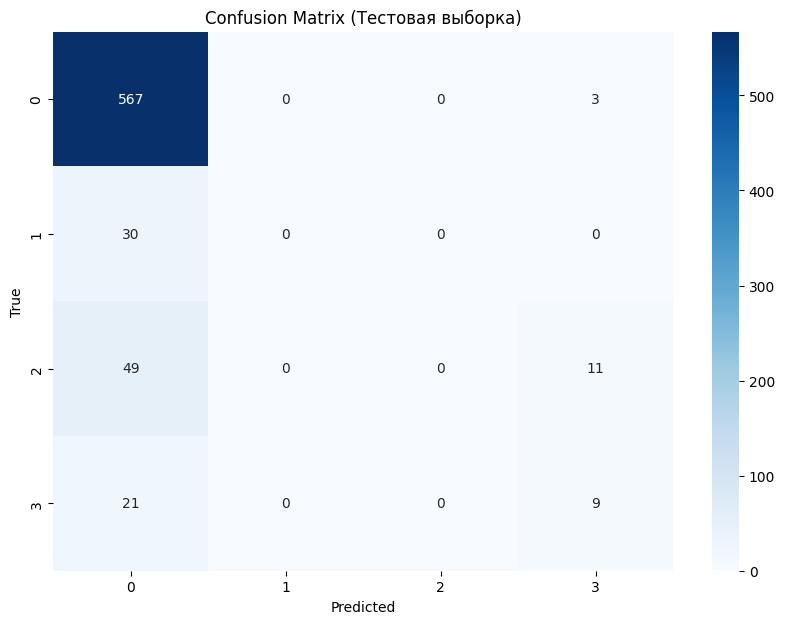

In [4]:
import numpy as np
import pandas as pd
from fedot.api.main import Fedot
from fedot.core.data.data import InputData
from fedot.core.data.data import Task, TaskTypesEnum, DataTypesEnum
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Предсказание на тестовой выборке
results = pipeline.predict(test_input)

# Преобразование результатов в понятный формат
y_pred = results

# Метрики на тестовой выборке
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f'Accuracy на тестовой выборке: {accuracy}')
print(f'F1-score на тестовой выборке: {f1}')
print(f'Precision на тестовой выборке: {precision}')
print(f'Recall на тестовой выборке: {recall}')
print('Classification Report:\n', report)

# Визуализация матрицы ошибок
plt.figure(figsize=(10, 7))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Тестовая выборка)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


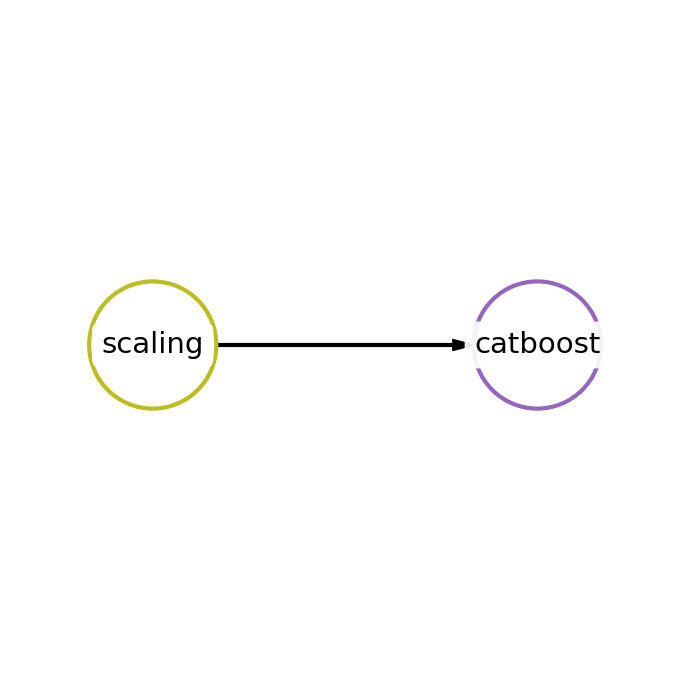

In [5]:
# Визуализация конфигурации пайплайна
pipeline.current_pipeline.show()

In [6]:
# Сохранение обученной модели
pipeline.current_pipeline.save(path="fedot_pipeline_anomaly_detection (0-3 not Park)")

# Сохранение предсказаний на тестовой выборке в CSV файл
output_path = "fedot_test_predictions (0-3 not Park).csv"
pd.DataFrame({'True Labels': y_test.values, 'Predictions': y_pred.flatten()}).to_csv(output_path, index=False)
print(f"Результаты сохранены в {output_path}")

Результаты сохранены в fedot_test_predictions (0-3 not Park).csv
